In [91]:
from PIL import Image, ImageOps, ImageFilter
import cv2
from pathlib import Path
from os import listdir
from os.path import isfile, join
from matplotlib import pyplot as plt
from skimage import data
from skimage.filters import unsharp_mask
from skimage.io import imread

from imutils import paths
import argparse
import cv2
import shutil

Use solaris conda env

In [2]:
data_dir = Path('data')

In [94]:
#clipped, rotated and reflected images
train_images = data_dir/'train/rotated/clipped/256'
test_images = data_dir/'test/rotated/clipped/256'
sharpend_dir = data_dir/'train/rotated/clipped/256/sharp_t100'
sharpend_dir.mkdir(exist_ok=True)
test_sharp_dir = data_dir/'test/rotated/clipped/256/sharp_t100'
test_sharp_dir.mkdir(exist_ok=True)

In [95]:
fnames = [f for f in listdir(train_images) if isfile(join(train_images, f))]
tnames = [f for f in listdir(test_images) if isfile(join(test_images, f))]

In [5]:
fnames[0]

'7a2e083e.tif'

In [104]:
assert len(fnames)==22555

In [103]:
assert len(tnames)==7325

In [55]:
def mpl_show(new_im, label, title=''):
    plt.imshow(new_im, interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    text = label+' '+title
    plt.title(text)
    plt.show()
    plt.close()

In [73]:
def mpl_2_plot(im1, title1, im2, title2):
    plt.figure(figsize=(8,4))
    plt.subplot(121)
    plt.imshow(im1)
    plt.title(title1, size=12)
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(im2)
    plt.title(title2, size=12)
    plt.axis('off')
    plt.tight_layout()
    plt.show()  

### Bluriness calculation
Some images are clearly blurry, lets see if we can identify these
see https://www.pyimagesearch.com/2015/09/07/blur-detection-with-opencv/

In [56]:
#focus measures that fall below this value will be considered 'blurry'
threshold=100.0

In [57]:
def variance_of_laplacian(image):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(image, cv2.CV_64F).var()

In [105]:
def calc_bluriness(images):
    image_quality={}
    fnames = [f for f in listdir(images) if isfile(join(images, f))]
    train_base=str(images)
    full_names=[train_base + '/' + s for s in fnames]
    print(f'{len(full_names)} images')
    i=0
    for imagePath in full_names:
        # load the image, convert it to grayscale, and compute the
        # focus measure of the image using the Variance of Laplacian
        # method
        if imagePath.endswith('.tif'):
            image = cv2.imread(imagePath)
            try:
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                fm = variance_of_laplacian(gray)
                text = "Not Blurry"

                # if the focus measure is less than the supplied threshold,
                # then the image should be considered "blurry"
                if fm < threshold:
                    text = "Blurry"
                id=str(Path(imagePath).name).split('.')[0]
                image_quality[id]=text
                if i<50:
                    mpl_show(image, id, text)
                i+=1
            except Exception as e:
                print(f'error with {imagePath}')
    return image_quality

22555 images


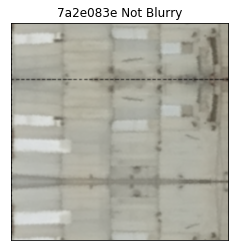

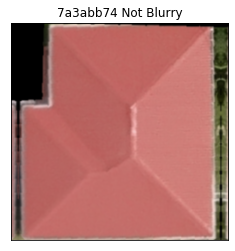

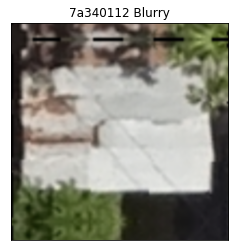

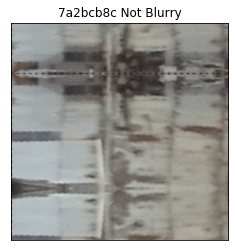

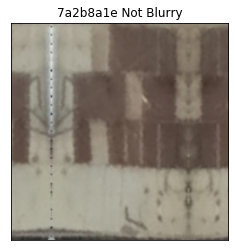

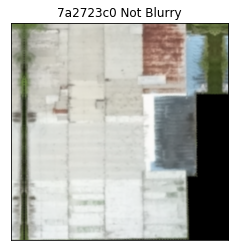

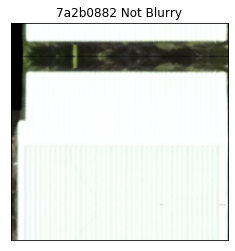

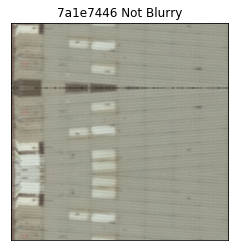

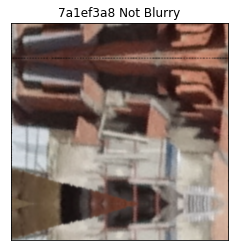

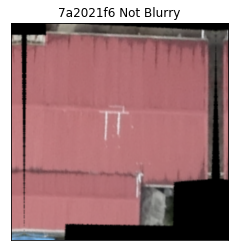

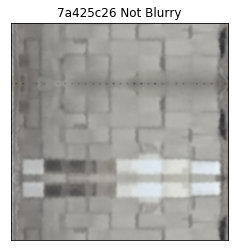

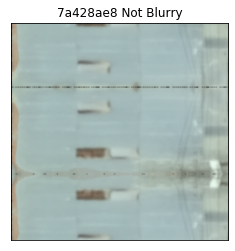

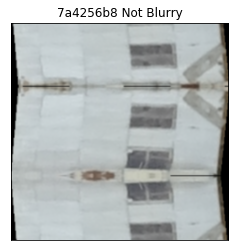

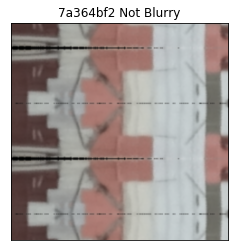

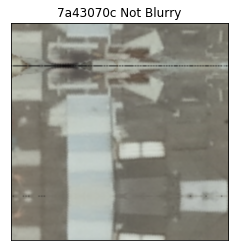

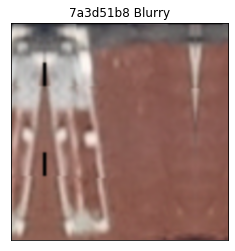

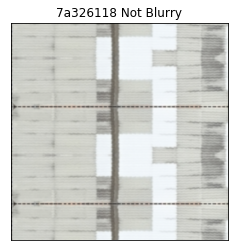

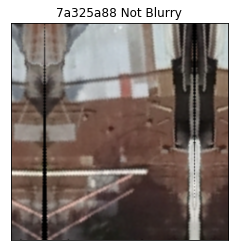

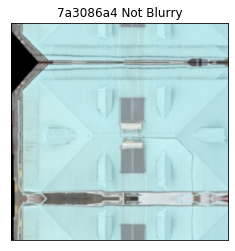

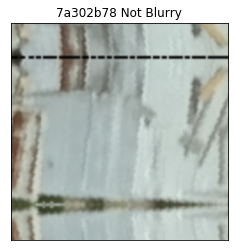

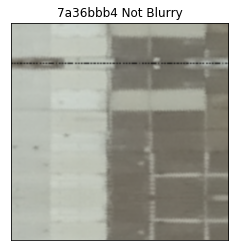

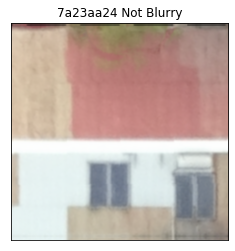

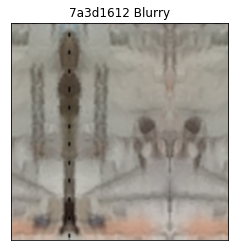

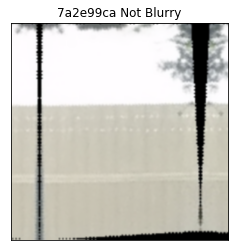

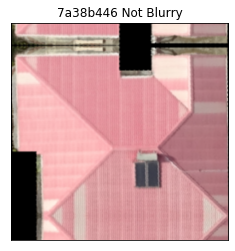

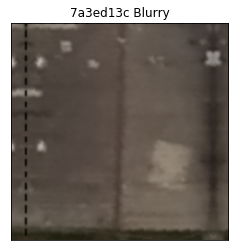

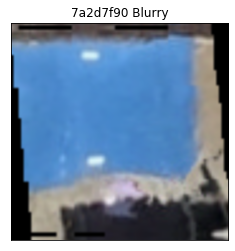

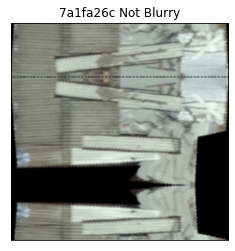

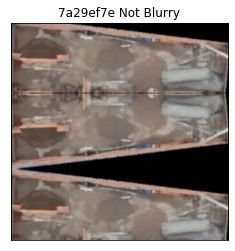

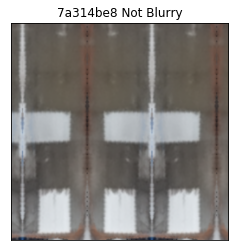

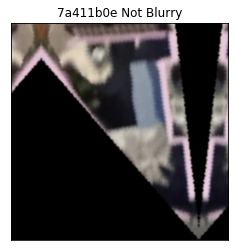

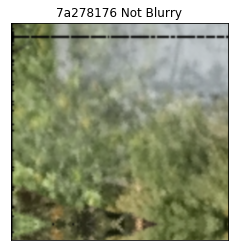

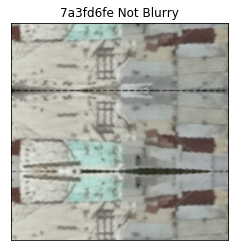

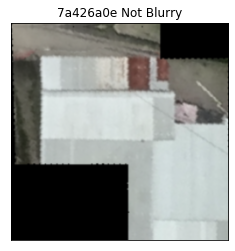

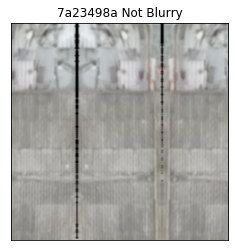

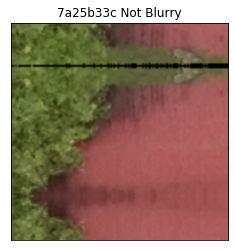

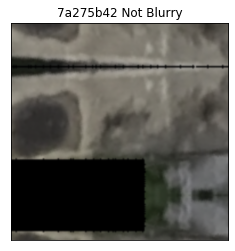

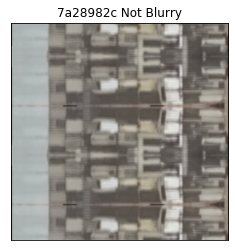

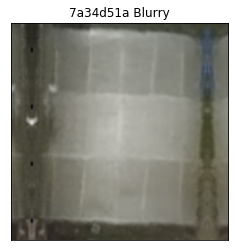

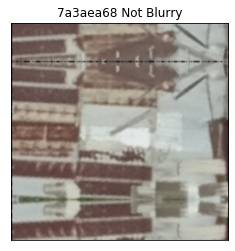

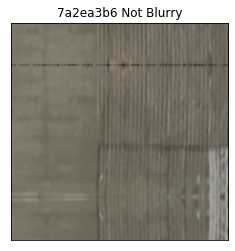

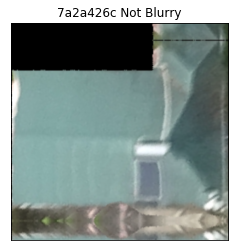

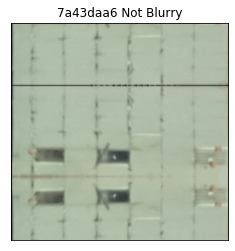

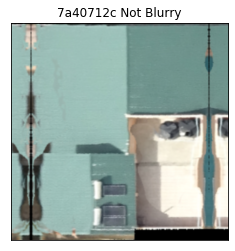

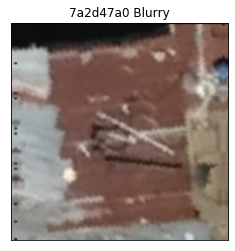

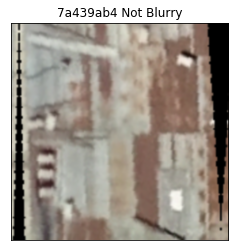

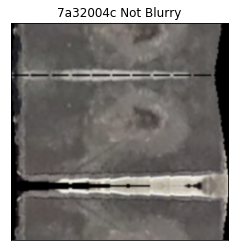

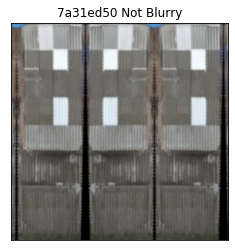

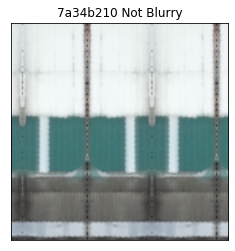

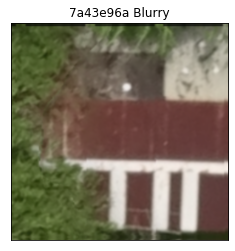

In [59]:
image_quality=calc_bluriness(train_images)

7325 images


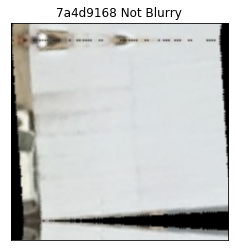

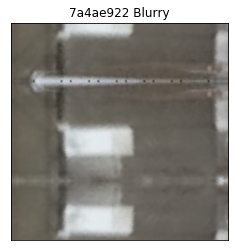

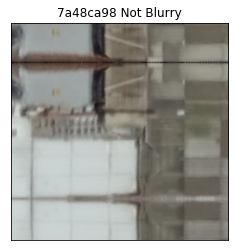

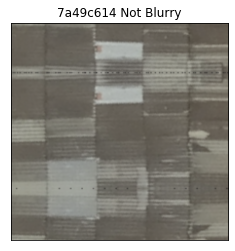

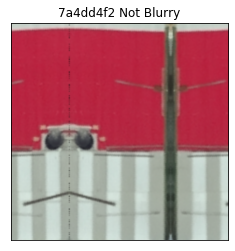

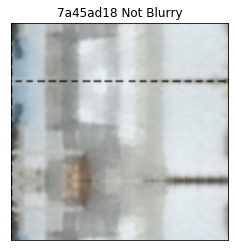

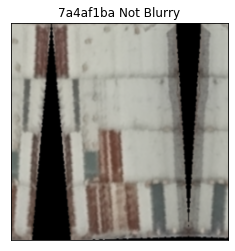

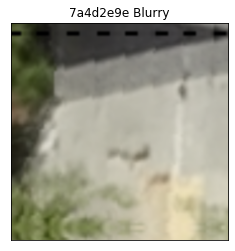

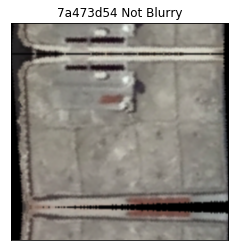

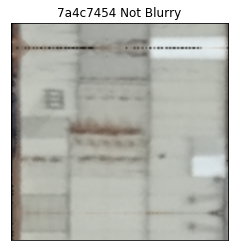

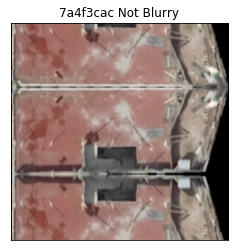

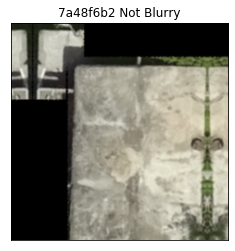

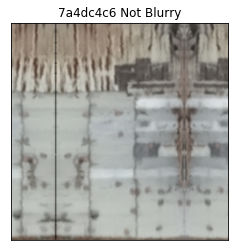

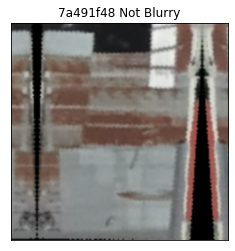

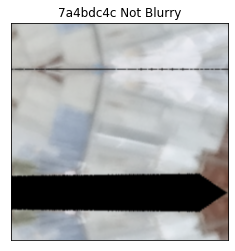

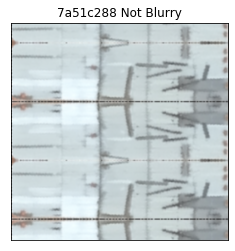

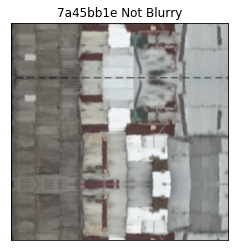

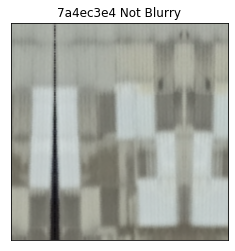

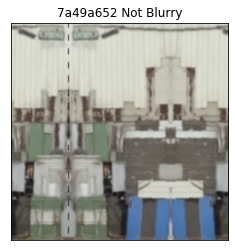

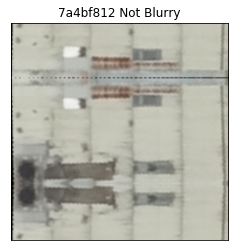

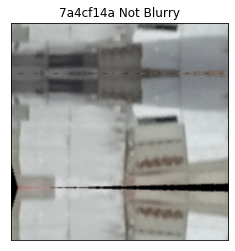

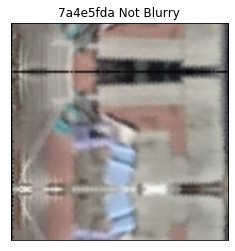

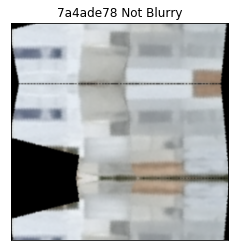

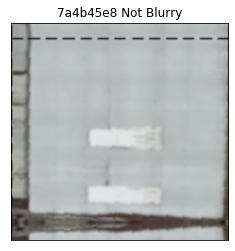

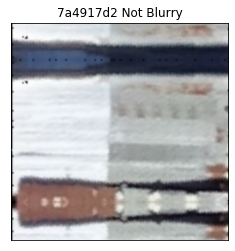

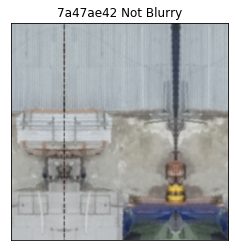

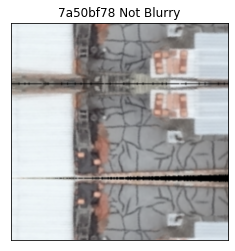

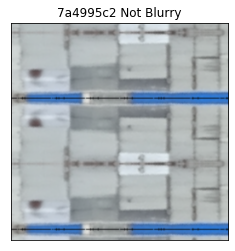

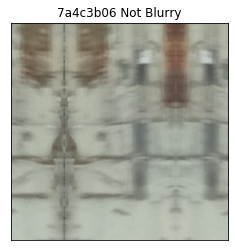

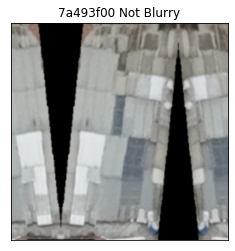

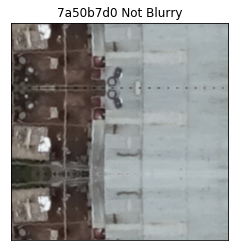

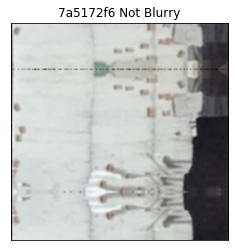

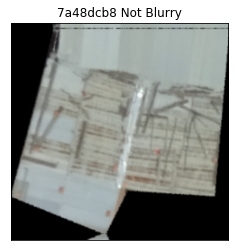

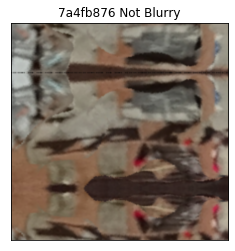

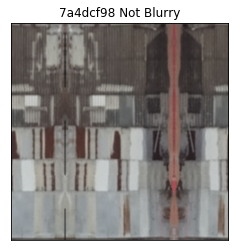

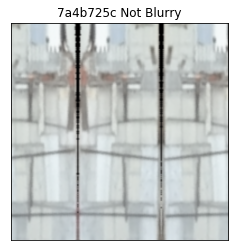

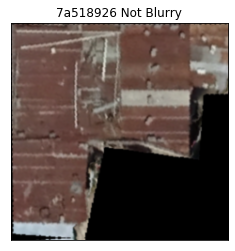

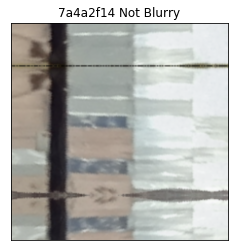

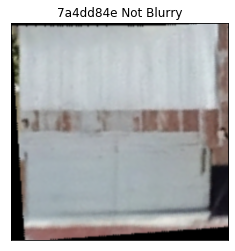

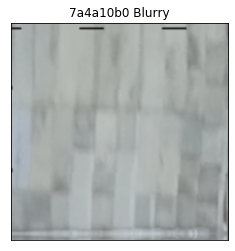

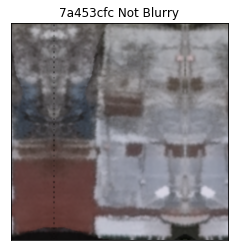

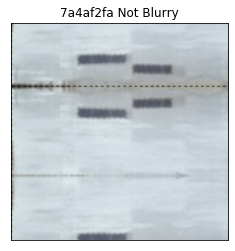

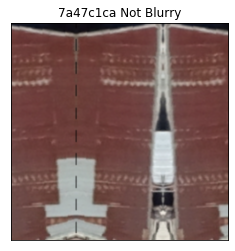

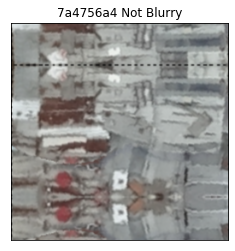

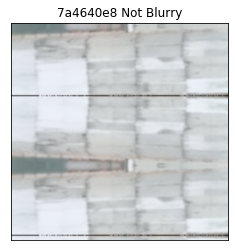

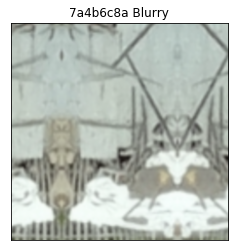

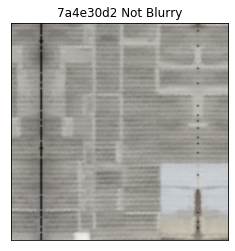

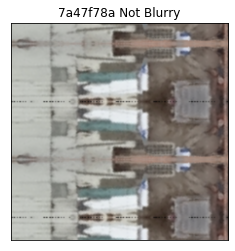

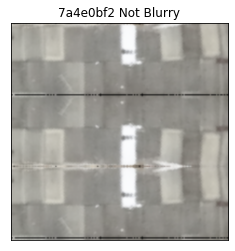

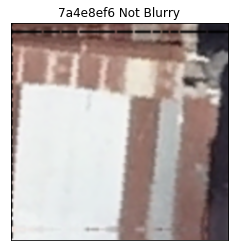

In [106]:
test_image_quality=calc_bluriness(test_images)

In [48]:
len(image_quality.keys())

22553

see Hands-On-Image-Processing-with-Python-master/Chapter5.ipynb

In [84]:
def pil_unsharp(image, radius, percent):
    im = Image.open(image)
    im1 = im.filter(ImageFilter.UnsharpMask(radius=radius, percent=percent))
    return im1

In [78]:
def skimage_unsharp_mark(img, radius, ammount):
    im = imread(img)
    im1 = unsharp_mask(im, radius=radius, amount=ammount)
    return im1

In [66]:
im = Image.open(train_images/'7a43e96a.tif')
sharp_im=pil_unsharp(train_images/'7a43e96a.tif',2,150)

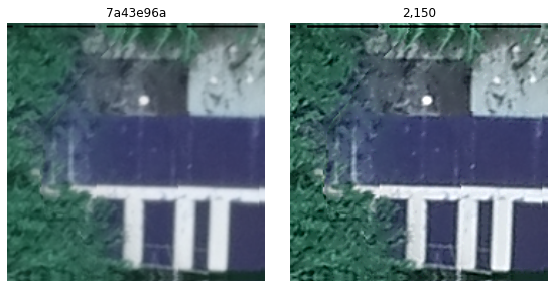

In [74]:
 mpl_2_plot(im, '7a43e96a', sharp_im, '2,150')

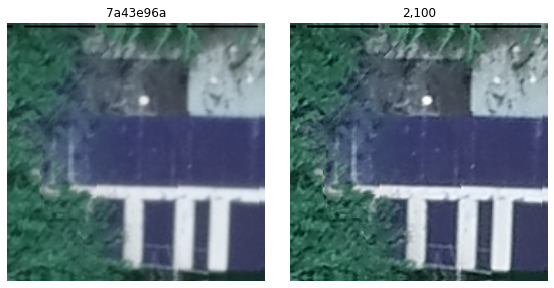

In [85]:
sharp_im=pil_unsharp(train_images/'7a43e96a.tif',2,100)
mpl_2_plot(im, '7a43e96a', sharp_im, '2,100')

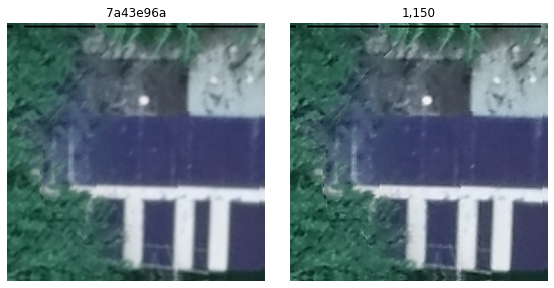

In [86]:
sharp_im=pil_unsharp(train_images/'7a43e96a.tif',1,150)
mpl_2_plot(im, '7a43e96a', sharp_im, '1,150')

### skimage

In [81]:
sharp_im=skimage_unsharp_mark(train_images/'7a43e96a.tif',1,2.0)

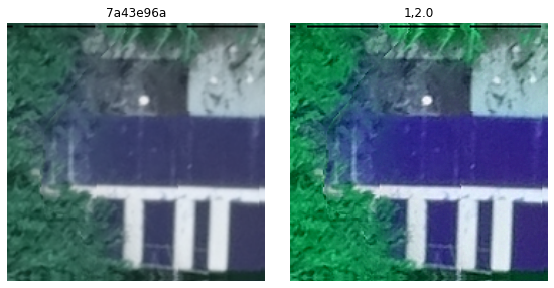

In [82]:
mpl_2_plot(im, '7a43e96a', sharp_im, '1,2.0')

Unsharpen mask in PIL looks to be doing a better job than skimage 

### sharpen all Blurred

In [89]:
radius=2
percent=150
for k, v in image_quality.items():
    if v=='Blurry':
        sharp_im=pil_unsharp(train_images/f'{k}.tif',radius,percent)
        sharp_im.save(train_images/f'sharp_t100/{k}.tif')

In [92]:
un_and_sharpend_dir = data_dir/'train/rotated/clipped/256/un_n_sharp_t100'
un_and_sharpend_dir.mkdir(exist_ok=True)
for k, v in image_quality.items():
    if v=='Blurry':
        shutil.copyfile(train_images/f'sharp_t100/{k}.tif', train_images/f'un_n_sharp_t100/{k}.tif')
    else:
        shutil.copyfile(train_images/f'{k}.tif', train_images/f'un_n_sharp_t100/{k}.tif')


#### test images

In [107]:
radius=2
percent=150
for k, v in test_image_quality.items():
    if v=='Blurry':
        sharp_im=pil_unsharp(test_images/f'{k}.tif',radius,percent)
        sharp_im.save(test_images/f'sharp_t100/{k}.tif')

In [108]:
un_and_sharpend_dir = data_dir/'test/rotated/clipped/256/un_n_sharp_t100'
un_and_sharpend_dir.mkdir(exist_ok=True)
for k, v in test_image_quality.items():
    if v=='Blurry':
        shutil.copyfile(test_images/f'sharp_t100/{k}.tif', test_images/f'un_n_sharp_t100/{k}.tif')
    else:
        shutil.copyfile(test_images/f'{k}.tif', test_images/f'un_n_sharp_t100/{k}.tif')
